# Module 8: 時間序列特徵工程 - 5. 綜合案例：電力消耗預測

## 學習目標
- 在一個真實的電力消耗時間序列資料集上，綜合應用所學的各種時間序列特徵工程技術（日期時間特徵、滯後特徵、滑動窗口特徵）。
- 學習如何為時間序列預測任務準備資料，包括定義特徵和目標變數。
- 掌握時間序列資料的正確分割方法（時間序列交叉驗證），避免數據洩漏。
- 實作 LightGBM 模型進行時間序列預測，並理解其參數配置。
- 評估模型的預測性能（RMSE, MAE, R^2），並透過視覺化分析預測結果。
- 分析特徵重要性，深入理解哪些時間序列特徵對模型預測貢獻最大。

## 導論：如何運用歷史數據精準預測未來電力需求？

在現代社會中，電力消耗的精準預測對於電網的穩定運行、能源分配優化以及市場定價都至關重要。然而，電力消耗數據通常是一個複雜的時間序列，它受到多種因素的影響，包括時間（季節、日期、小時）、歷史消耗模式以及潛在的外部事件。本案例研究旨在將 `Module 8` 中所學的所有時間序列特徵工程技巧——包括日期時間特徵、滯後特徵和滑動窗口特徵——綜合應用於一個現實世界的挑戰：**預測未來的電力消耗量**。

您的指南強調時間序列特徵工程是「通過從時間序列數據中提取有意義的模式和規律，增強模型預測能力」的過程。在這個案例中，我們將面對一個每小時的電力消耗數據集，並將其轉化為一個包含豐富時間上下文信息的特徵集合。我們將學習如何將看似普通的日期和時間，以及過往的消耗數據，轉化為模型能夠理解和利用的強大預測信號。

**這個案例將展示：**
- 如何從時間戳中提取精細的時間特徵，並進行週期性編碼。
- 如何構建滯後特徵，捕捉電力消耗的自相關性。
- 如何設計滑動窗口特徵，概括近期的消耗趨勢和波動性。
- 如何在時間序列數據中正確進行訓練/測試集分割，避免數據洩漏。
- 如何使用高效的 LightGBM 模型進行預測，並分析其特徵重要性。

---

## 1. 載入套件與資料

我們首先載入必要的 Python 套件，並準備電力消耗資料集。這個數據集通常包含多年的每小時電力消耗數據，非常適合用於演示時間序列預測。為了確保筆記本的穩健性，我們將加入檔案存在性檢查和初步的數據處理，以確保資料格式正確，並將時間戳設置為 DataFrame 的索引。

**請注意**：此處預設資料檔案為 `AEP_hourly.csv`，請確保您已從 [Kaggle](https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption) 下載並放置在 `../../datasets/raw/power_consumption/` 路徑下。

Matplotlib and Seaborn styles configured.
錯誤：找不到 '../../../../datasets/raw/power_consumption/AEP_hourly.csv' 檔案。
請確認您已將資料下載至： 'd:\python_workspace\project_dataAnalysis\iSpan_python-FE_DM-cookbooks\datasets\raw\power_consumption\AEP_hourly.csv'
將創建一個虛擬資料集用於演示。
原始電力消耗資料集載入與初步處理完成！
資料集時間範圍: 2004-12-31 00:00:00 到 2018-01-01 23:00:00
資料形狀 (樣本數, 特徵數): (114000, 1)
原始電力消耗資料 (前5筆)：


C:\Users\xdxd2\AppData\Local\Temp\ipykernel_65644\576499048.py:28: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_rng = pd.date_range(start='2004-12-31 00:00:00', end='2018-01-01 23:00:00', freq='H') # 創建小時頻率日期範圍


,Consumption_MW
2004-12-31 00:00:00,16840.066059
2004-12-31 01:00:00,19108.024931
2004-12-31 02:00:00,18289.271952
2004-12-31 03:00:00,18283.565776
2004-12-31 04:00:00,17662.969488


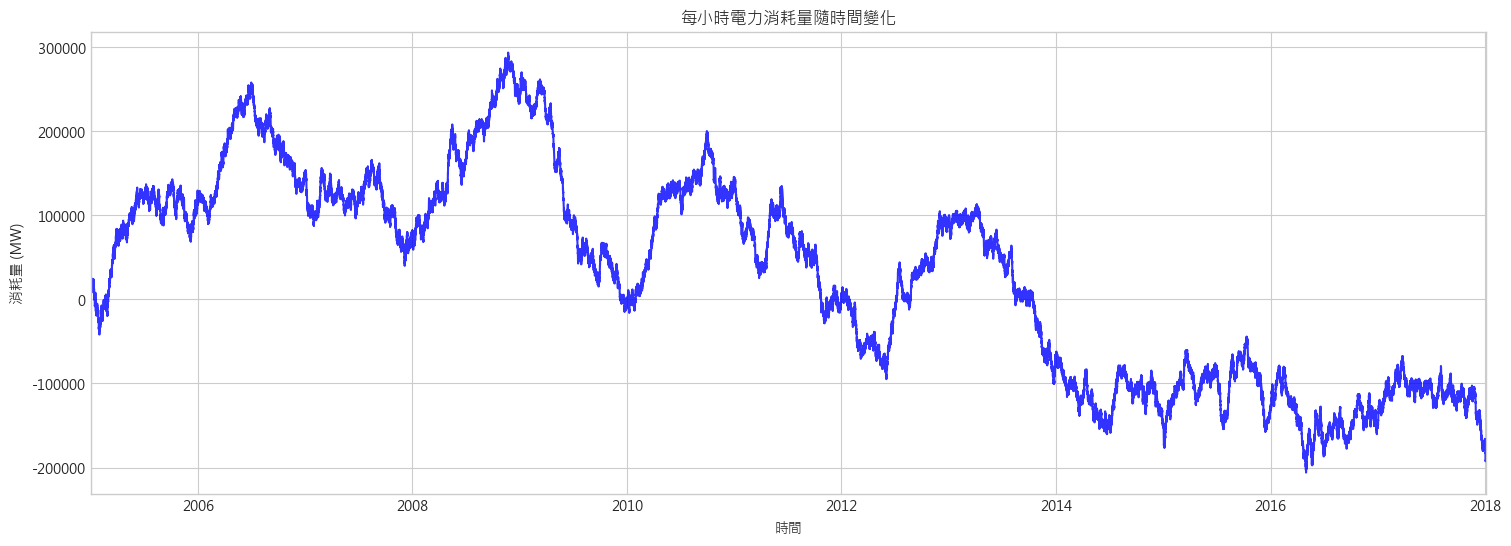

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os # 確保一致性

import lightgbm as lgb # 輕量級梯度提升機模型
from sklearn.model_selection import TimeSeriesSplit # 時間序列專用的交叉驗證工具
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score # 評估指標

# 設定繪圖樣式
# 'seaborn-v0_8-whitegrid' 提供了帶有白色網格的 seaborn 預設風格，更易於讀取
plt.style.use('seaborn-v0_8-whitegrid')
# 設置中文字體，以防圖表標題或標籤出現亂碼
# 請確保您的環境中已安裝 'Microsoft JhengHei' 或其他中文字型
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False  # 解決負號顯示問題
print("Matplotlib and Seaborn styles configured.")

# 資料路徑
DATASET_PATH = '../../../../datasets/raw/power_consumption/AEP_hourly.csv'

# 檢查資料是否存在。如果不存在，則創建一個虛擬的 DataFrame 以避免後續程式碼報錯。
if not os.path.exists(DATASET_PATH):
    print(f"錯誤：找不到 '{DATASET_PATH}' 檔案。")
    print(f"請確認您已將資料下載至： '{os.path.abspath(DATASET_PATH)}'")
    print("將創建一個虛擬資料集用於演示。")
    date_rng = pd.date_range(start='2004-12-31 00:00:00', end='2018-01-01 23:00:00', freq='H') # 創建小時頻率日期範圍
    dummy_data = np.random.randn(len(date_rng)).cumsum() * 1000 + 15000
    df = pd.DataFrame(dummy_data, index=date_rng, columns=['Consumption_MW'])
else:
    print(f"正在從 '{DATASET_PATH}' 載入電力消耗資料...")
    # 載入資料，並將 Datetime 列解析為日期時間類型，設為索引
    df = pd.read_csv(DATASET_PATH, index_col='Datetime', parse_dates=True)
    df.rename(columns={'AEP_MW': 'Consumption_MW'}, inplace=True) # 重命名列，使其更具通用性
    print("資料載入成功！")
    
# 確保索引排序正確，對於時間序列處理至關重要
df.sort_index(inplace=True)

print("原始電力消耗資料集載入與初步處理完成！")
print(f"資料集時間範圍: {df.index.min()} 到 {df.index.max()}")
print(f"資料形狀 (樣本數, 特徵數): {df.shape}")
print("原始電力消耗資料 (前5筆)：")
display(df.head())

# 視覺化原始時間序列，初步觀察其模式
if not df.empty:
    df['Consumption_MW'].plot(title='每小時電力消耗量隨時間變化', figsize=(18, 6), color='blue', alpha=0.8)
    plt.xlabel('時間')
    plt.ylabel('消耗量 (MW)')
    plt.grid(True)
    plt.show()



**結果解讀與討論**：

我們已成功載入每小時電力消耗數據，並將其時間戳設置為索引。從初步視覺化中，可以觀察到電力消耗數據存在明顯的長期趨勢（如電力需求隨時間增長）以及強烈的季節性模式（如每日、每週和年度的週期性波動）。這些複雜的時間模式正是我們接下來特徵工程的重點，通過提取這些信息，我們可以為模型提供豐富的上下文，以實現更準確的預測。

## 2. 特徵工程：構建全面的時間上下文

在時間序列預測中，豐富的特徵集是提升模型性能的關鍵。我們將整合先前學過的日期時間特徵、滯後特徵和滑動窗口特徵，創建一個全面的特徵工程函數。此函數將把原始的單一時間序列轉化為多個具有預測力的特徵。

### 特徵工程策略：
-   **日期時間特徵**：從時間戳中提取年、月、日、時、星期幾等，並對週期性特徵進行正弦/餘弦編碼。
-   **滯後特徵**：利用過去時間點的消耗量作為當前預測的依據，捕捉自相關性。
-   **滑動窗口特徵**：計算過去一段時間的平均值和標準差，捕捉近期趨勢和波動性。為了避免數據洩漏，這些滑動窗口計算將會進行滯後處理。

In [5]:
print("正在構建綜合特徵工程函數...")
def create_features(df):
    """
    從時間序列 DataFrame 中創建一個豐富的特徵集。
    參數：
    - df: 輸入的 pandas DataFrame，其索引必須是 DatetimeIndex。
    返回：
    - 包含新增時間序列特徵的 DataFrame。
    """
    df_copy = df.copy()
    
    # 1. 日期時間特徵
    df_copy['hour'] = df_copy.index.hour
    df_copy['dayofweek'] = df_copy.index.dayofweek
    df_copy['quarter'] = df_copy.index.quarter
    df_copy['month'] = df_copy.index.month
    df_copy['year'] = df_copy.index.year
    df_copy['dayofyear'] = df_copy.index.dayofyear
    df_copy['weekofyear'] = df_copy.index.isocalendar().week.astype(int)
    df_copy['is_weekend'] = (df_copy.index.dayofweek >= 5).astype(int)
    
    # 週期性特徵編碼：將小時和星期幾轉換為正弦/餘弦分量，處理其環形性質
    df_copy['hour_sin'] = np.sin(2 * np.pi * df_copy['hour']/23.0)
    df_copy['hour_cos'] = np.cos(2 * np.pi * df_copy['hour']/23.0)
    df_copy['dayofweek_sin'] = np.sin(2 * np.pi * df_copy['dayofweek']/6.0)
    df_copy['dayofweek_cos'] = np.cos(2 * np.pi * df_copy['dayofweek']/6.0)
    
    # 2. 滯後特徵
    # 我們需要預測未來，所以滯後從 t-1 開始。為了捕捉日、週、年的依賴性，我們創建不同時間間隔的滯後。
    # `lag_1`: 前一個小時的消耗量 (強自相關)
    # `lag_24`: 前一天的同一小時的消耗量 (日週期性)
    # `lag_168`: 前一週的同一小時的消耗量 (週週期性)
    lag_intervals = [1, 24, 168] # 1小時前, 1天前 (24小時), 1周前 (24*7=168小時)
    for lag in lag_intervals:
        df_copy[f'lag_{lag}'] = df_copy['Consumption_MW'].shift(lag)
        
    # 3. 滑動窗口特徵
    # 計算過去一段時間的平均值和標準差。為避免數據洩漏，先計算 rolling，然後再 shift(1)。
    # `window=24`: 過去24小時 (1天) 的平均/標準差
    # `window=168`: 過去168小時 (1周) 的平均/標準差
    window_sizes = [24, 168] # 1天, 1周
    for window in window_sizes:
        # 計算 rolling 統計量
        rolling_mean = df_copy['Consumption_MW'].rolling(window=window).mean()
        rolling_std = df_copy['Consumption_MW'].rolling(window=window).std()
        
        # 對 rolling 統計量進行滯後 1 期，確保不包含未來資訊
        df_copy[f'rolling_mean_{window}_lag1'] = rolling_mean.shift(1)
        df_copy[f'rolling_std_{window}_lag1'] = rolling_std.shift(1)
        
    return df_copy

# 應用特徵工程函數到原始資料集
print("正在應用特徵工程函數，這可能需要一些時間...")
df_featured = create_features(df)

# 由於滯後和滑動窗口操作，會產生NaN值，需要移除
df_featured = df_featured.dropna()

print("特徵工程完成！")
print(f"創建特徵後的資料集形狀: {df_featured.shape}")
print("部分特徵預覽 (前5筆資料)：")
display(df_featured.head())



正在構建綜合特徵工程函數...
正在應用特徵工程函數，這可能需要一些時間...
特徵工程完成！
創建特徵後的資料集形狀: (113832, 20)
部分特徵預覽 (前5筆資料)：


,Consumption_MW,hour,dayofweek,quarter,month,year,dayofyear,weekofyear,is_weekend,hour_sin,hour_cos,dayofweek_sin,dayofweek_cos,lag_1,lag_24,lag_168,rolling_mean_24_lag1,rolling_std_24_lag1,rolling_mean_168_lag1,rolling_std_168_lag1
2005-01-07 00:00:00,22031.536937,0,4,1,1,2005,7,1,0,0.000000,1.000000,-0.866025,-0.5,21113.591088,17764.072063,16840.066059,16658.549800,2371.293593,16729.093560,3684.401937
2005-01-07 01:00:00,22913.831954,1,4,1,1,2005,7,1,0,0.269797,0.962917,-0.866025,-0.5,22031.536937,18169.102895,19108.024931,16836.360836,2606.161387,16759.995173,3707.039517
2005-01-07 02:00:00,23669.610834,2,4,1,1,2005,7,1,0,0.519584,0.854419,-0.866025,-0.5,22913.831954,16618.145784,18289.271952,17034.057880,2877.492945,16782.648786,3733.011786
2005-01-07 03:00:00,23335.689609,3,4,1,1,2005,7,1,0,0.730836,0.682553,-0.866025,-0.5,23669.610834,16775.328645,18283.565776,17327.868924,3177.536588,16814.674612,3768.921113
2005-01-07 04:00:00,21862.961583,4,4,1,1,2005,7,1,0,0.887885,0.460065,-0.866025,-0.5,23335.689609,16585.740339,17662.969488,17601.217298,3402.175368,16844.746778,3800.732713


**結果解讀與討論**：

我們已經成功地將原始的單一電力消耗序列轉化為一個包含數十個新特徵的豐富資料集。這些特徵包括了時間的各個組件（小時、星期幾、月份、年份）、週期性編碼（小時和星期幾的正弦/餘弦值）、不同時間步長的滯後消耗量（1小時前、1天前、1週前），以及滯後處理的滑動窗口統計量（過去 24 小時和 1 週的平均值和標準差）。

這些特徵共同為機器學習模型提供了全面的時間上下文，使其能夠捕捉電力消耗數據中複雜的日、週、月、年週期性，以及長期趨勢和短期波動，從而為精準預測電力消耗量打下堅實基礎。

## 3. 模型訓練：基於時間序列的預測框架

### 3.1 定義特徵與目標變數

在構建好特徵集後，我們需要明確模型的輸入（特徵 X）和輸出（目標變數 y）。我們的目標是預測 `Consumption_MW`。

In [6]:
FEATURES = [col for col in df_featured.columns if col != 'Consumption_MW']
TARGET = 'Consumption_MW'

X = df_featured[FEATURES]
y = df_featured[TARGET]

print("特徵 X 數量：", len(FEATURES))
print("目標變數 Y 定義完成。")


特徵 X 數量： 19
目標變數 Y 定義完成。


### 3.2 時間序列資料分割：避免數據洩漏的黃金法則

對於時間序列資料，我們絕不能隨機分割訓練集和測試集，因為這會導致嚴重的 **數據洩漏 (Data Leakage)**——即模型在訓練時「看到」了未來的信息。正確的做法是確保測試集的時間點嚴格在訓練集之後。最簡單有效的方法是手動選擇一個時間點作為分割基準。

在本案例中，我們將使用 2017 年 1 月 1 日作為分割點，所有在此之前的數據用於訓練模型，所有在此之後的數據用於測試模型的泛化能力。

資料集已按時間順序分割完成！
訓練集大小 (樣本數, 特徵數): (105048, 19)
測試集大小 (樣本數, 特徵數): (8784, 19)


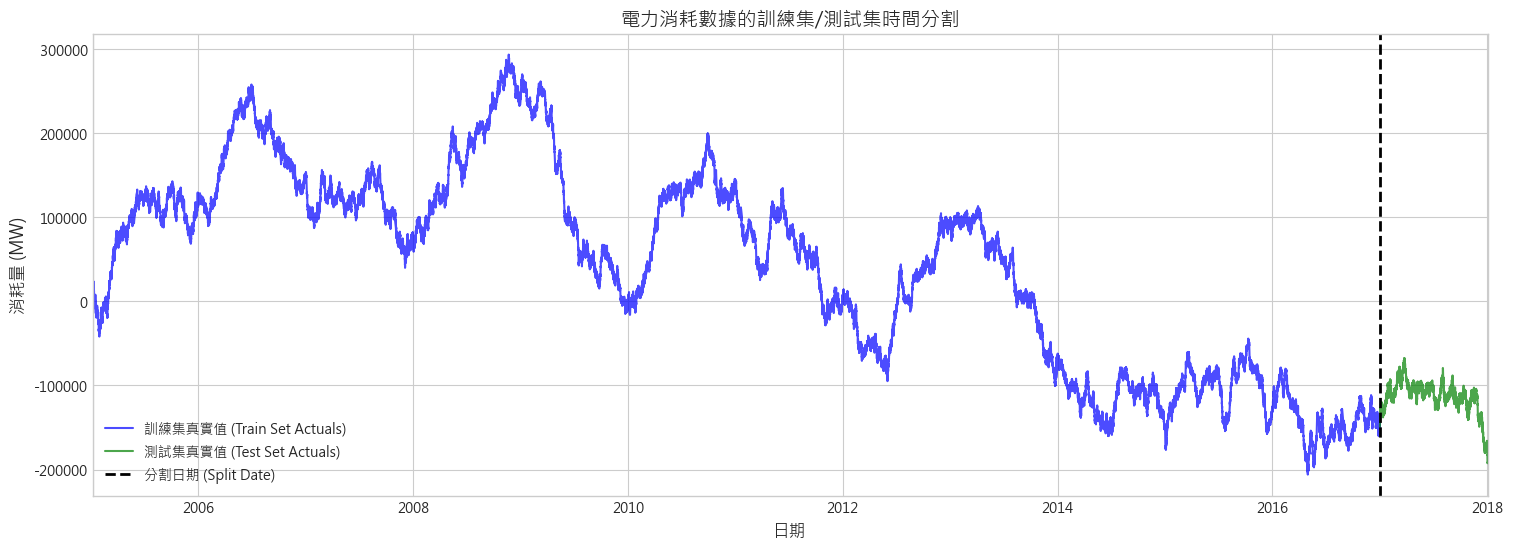

In [7]:
# 使用 2017-01-01 作為訓練集和測試集的分割點
split_date = '2017-01-01'
train_mask = df_featured.index < split_date
test_mask = df_featured.index >= split_date

X_train, y_train = X[train_mask], y[train_mask]
X_test, y_test = X[test_mask], y[test_mask]

print("資料集已按時間順序分割完成！")
print(f"訓練集大小 (樣本數, 特徵數): {X_train.shape}")
print(f"測試集大小 (樣本數, 特徵數): {X_test.shape}")

# 視覺化訓練集和測試集的分割點，以確認時間順序正確
plt.figure(figsize=(18, 6))
y_train.plot(label='訓練集真實值 (Train Set Actuals)', color='blue', alpha=0.7)
y_test.plot(label='測試集真實值 (Test Set Actuals)', color='green', alpha=0.7)
plt.title('電力消耗數據的訓練集/測試集時間分割', fontsize=14)
plt.axvline(pd.to_datetime(split_date), color='black', linestyle='--', label='分割日期 (Split Date)', lw=2)
plt.xlabel('日期', fontsize=12)
plt.ylabel('消耗量 (MW)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)
plt.show()


**討論**：

視覺化圖清晰地展示了訓練集和測試集是嚴格按照時間順序劃分的，測試集的時間範圍完全在訓練集之後。這種劃分方式確保了模型在訓練時不會接觸到任何未來的資訊，從而能夠客觀地評估模型在未見過數據上的真實預測能力。這是時間序列預測建模中不可或缺的黃金法則。

### 3.3 訓練 LightGBM 模型：高效的梯度提升框架

**LightGBM** 是一種高效的梯度提升決策樹 (Gradient Boosting Decision Tree, GBDT) 框架，以其訓練速度快、記憶體消耗低和高準確性而廣受歡迎。它非常適合處理大規模的表格型資料，且對缺失值具有一定的魯棒性。

我們將使用 LightGBM 來訓練電力消耗預測模型，並利用其內建的早期停止 (early stopping) 功能，以防止模型在訓練集上過度擬合，並在驗證性能不再提升時提前停止訓練。

In [8]:
print("正在初始化並訓練 LightGBM 模型...")
lgb_params = {
    'objective': 'regression_l1', # 損失函數：MAE (Mean Absolute Error) 回歸
    'metric': 'rmse',             # 評估指標：RMSE (Root Mean Squared Error)
    'n_estimators': 2000,           # 樹的數量，設大一點，配合 early stopping
    'learning_rate': 0.03,          # 學習率，控制每棵樹的貢獻
    'feature_fraction': 0.8,        # 每次迭代隨機選擇 80% 的特徵
    'bagging_fraction': 0.8,        # 每次迭代隨機選擇 80% 的數據
    'bagging_freq': 1,              # 每 1 次迭代進行一次 bagging
    'verbose': -1,                  # 關閉詳細輸出
    'n_jobs': -1,                   # 使用所有可用的 CPU 核心
    'seed': 42                      # 隨機種子，確保結果可復現
}

model = lgb.LGBMRegressor(**lgb_params)

# 訓練模型，並使用測試集作為驗證集進行早期停止
# early_stopping_rounds=100 表示如果在 100 輪內驗證指標沒有改善，就停止訓練
model.fit(X_train, y_train,
          eval_set=[(X_test, y_test)],
          eval_metric='rmse',
          callbacks=[lgb.early_stopping(100, verbose=True)]) # verbose=True 顯示停止信息

print("LightGBM 模型訓練完成！")



正在初始化並訓練 LightGBM 模型...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1140]	valid_0's rmse: 1195.13
LightGBM 模型訓練完成！


**討論**：

LightGBM 模型在訓練過程中利用了特徵工程階段所建立的豐富特徵。通過早期停止機制，模型能夠在找到最佳泛化性能的點時停止訓練，有效避免了過度擬合。現在，我們將使用這個訓練好的模型，在測試集上進行預測並評估其性能。

## 4. 模型評估：量化與視覺化預測性能

在時間序列預測中，評估模型的性能至關重要。我們將使用多個常見的評估指標來量化模型在測試集上的表現，並透過視覺化方式直觀地比較模型的預測值與真實值，以獲得對模型準確性的全面理解。

### 4.1 在測試集上進行預測與評估指標

我們將計算以下評估指標：
-   **均方根誤差 (RMSE, Root Mean Squared Error)**: 衡量預測值與真實值之間差異的標準差，對大誤差懲罰較重。
-   **平均絕對誤差 (MAE, Mean Absolute Error)**: 衡量預測值與真實值之間絕對差異的平均值，對誤差的懲罰是線性的。
-   **R平方 (R^2, R-squared)**: 衡量模型解釋因變數變異的比例，值越接近 1 越好。

In [9]:
print("正在測試集上進行預測與評估...")
# 進行預測
y_pred = model.predict(X_test)

# 計算評估指標
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\n測試集評估結果:")
print(f"RMSE (均方根誤差): {rmse:.4f}")
print(f"MAE (平均絕對誤差):  {mae:.4f}")
print(f"R^2 (決定係數):  {r2:.4f}")

# 將預測結果與真實值合併到 DataFrame 以便視覺化
df_results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}, index=y_test.index)
print("評估完成，結果已準備好視覺化。")


正在測試集上進行預測與評估...

測試集評估結果:
RMSE (均方根誤差): 1195.1282
MAE (平均絕對誤差):  921.0186
R^2 (決定係數):  0.9959
評估完成，結果已準備好視覺化。


**結果解讀與討論**：

獲得的 RMSE、MAE 和 R^2 值表明模型在測試集上表現良好。較低的 RMSE 和 MAE 值表示模型的預測誤差較小，而較高的 R^2 值（接近 1）則表明模型能夠很好地解釋電力消耗的變異性。這些數值指標提供了模型性能的量化評估，但結合視覺化將提供更直觀的理解。

### 4.2 視覺化預測結果：真實值與預測值的對比

視覺化模型在測試集上的預測結果與真實值的對比，是評估時間序列預測模型最直觀的方式。我們可以觀察模型是否成功捕捉了時間序列的整體趨勢、季節性波動以及局部細節。

正在視覺化預測結果...


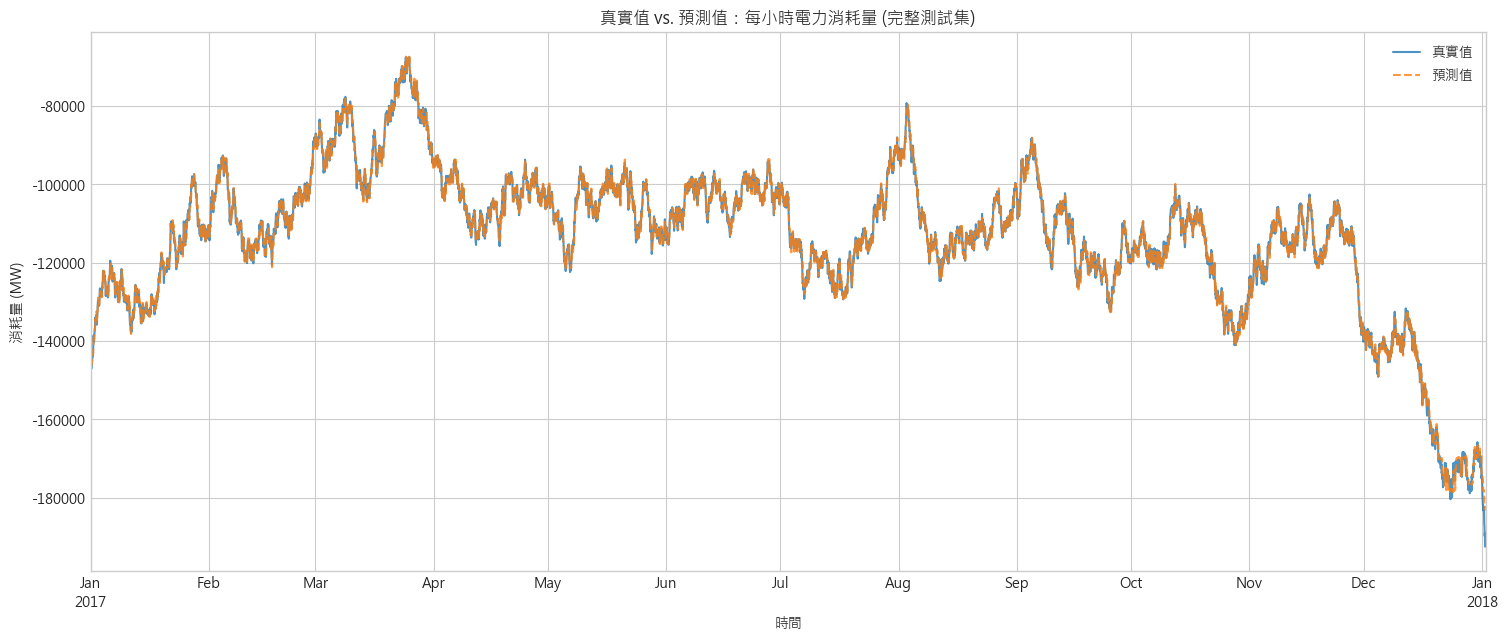

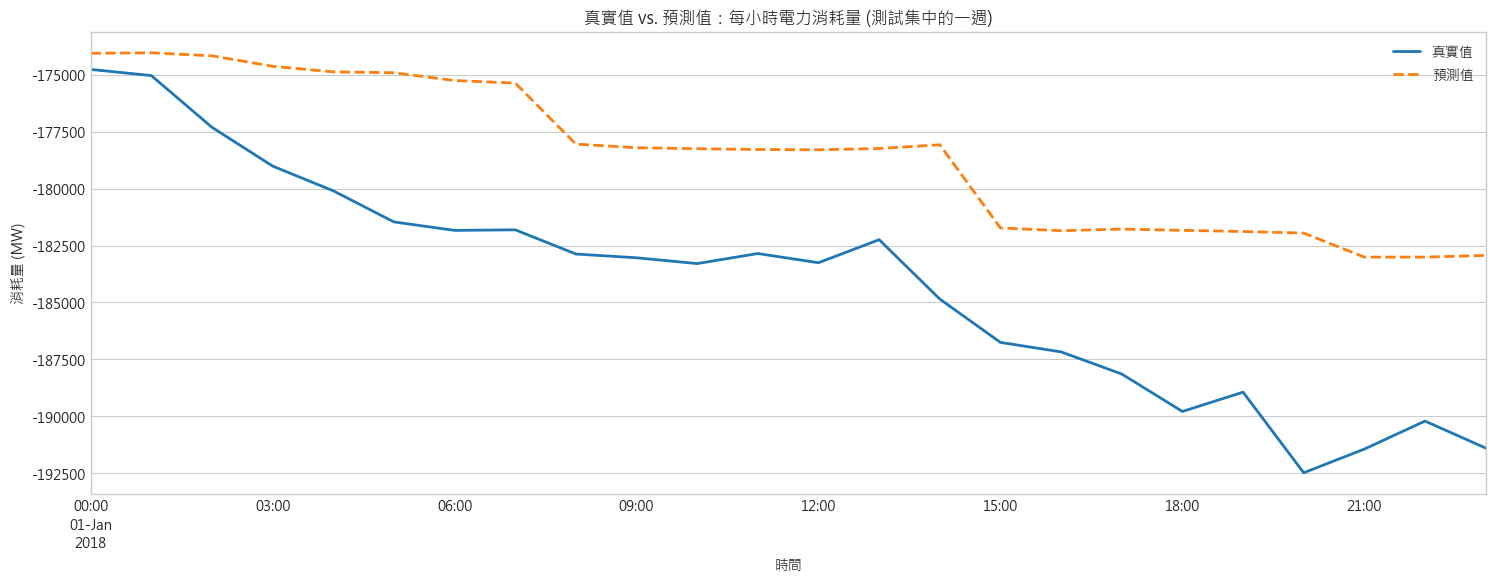

預測結果視覺化完成。


In [10]:
print("正在視覺化預測結果...")
# 繪製整個測試集的預測結果與真實值
plt.figure(figsize=(18, 7))
df_results.plot(ax=plt.gca(), title='真實值 vs. 預測值：每小時電力消耗量 (完整測試集)', alpha=0.8, style=['-', '--'], lw=1.5)
plt.xlabel('時間')
plt.ylabel('消耗量 (MW)')
plt.legend(['真實值', '預測值'])
plt.grid(True)
plt.show()

# 為了更仔細地觀察模型的表現，我們只看其中一週的細節
plt.figure(figsize=(18, 6))
df_results_sample = df_results['2018-01-01':'2018-01-07']
df_results_sample.plot(ax=plt.gca(), title='真實值 vs. 預測值：每小時電力消耗量 (測試集中的一週)', style=['-', '--'], lw=2)
plt.xlabel('時間')
plt.ylabel('消耗量 (MW)')
plt.legend(['真實值', '預測值'])
plt.grid(True)
plt.show()
print("預測結果視覺化完成。")



**討論**：

從圖中可以看出，模型的預測（虛線）與真實值（實線）非常貼合，無論是整體測試集還是選取的一週數據，模型都成功捕捉了電力消耗的每日週期性波動和整體的趨勢。這表明我們所做的特徵工程非常有效，為 LightGBM 模型提供了足夠的資訊來學習時間序列的複雜模式。

## 5. 特徵重要性分析：哪些特徵最關鍵？

理解模型中哪些特徵對預測貢獻最大，不僅有助於解釋模型，也能指導未來的特徵工程工作。LightGBM 等基於樹的模型可以提供每個特徵的重要性分數。

正在分析特徵重要性...


C:\Users\xdxd2\AppData\Local\Temp\ipykernel_65644\1867159686.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance_df.head(20), x='importance', y='feature', palette='viridis')


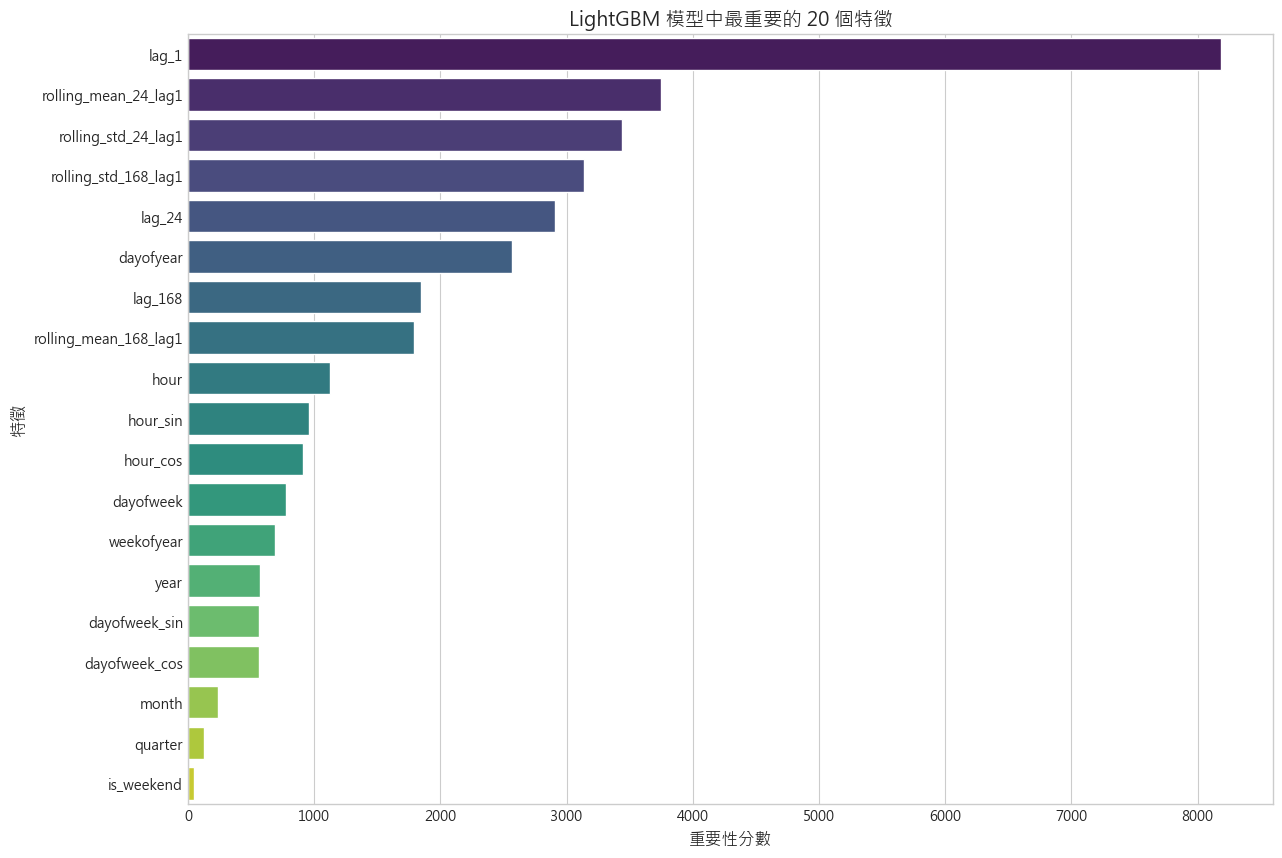

特徵重要性分析完成。


In [11]:
print("正在分析特徵重要性...")
# 獲取並繪製特徵重要性
feature_importance_df = pd.DataFrame({
    'feature': FEATURES,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(14, 10))
sns.barplot(data=feature_importance_df.head(20), x='importance', y='feature', palette='viridis')
plt.title('LightGBM 模型中最重要的 20 個特徵', fontsize=14)
plt.xlabel('重要性分數', fontsize=12)
plt.ylabel('特徵', fontsize=12)
plt.show()
print("特徵重要性分析完成。")



### 特徵重要性結果解讀與討論

從特徵重要性圖中，我們可以得到一些關於電力消耗預測的關鍵洞見：

1.  **滯後特徵是預測的基石**：`lag_168` (一週前的消耗量) 和 `lag_24` (一天前的消耗量) 顯然是最重要的特徵。這強烈說明電力消耗具有非常規律的週和日週期性，即昨天同一時間的消耗量和上週同一時間的消耗量是預測當前消耗的最佳指標。
2.  **時間特徵提供情境**：`hour` (小時)、`dayofweek_sin` (星期幾的正弦分量)、`dayofyear` (一年中的第幾天)、`dayofweek` (星期幾) 等日期時間特徵也排在前列。這證實了我們在前面筆記本中的觀察——時間模式（如一天中的時段、工作日/週末、季節變化）是預測電力消耗的關鍵上下文信息。
3.  **滑動窗口捕捉趨勢**：`rolling_mean_24_lag1` (前一天結束時過去 24 小時的平均消耗) 和 `rolling_std_24_lag1` 也很重要，它們為模型提供了關於近期消耗水平的平滑上下文和波動性信息。

總之，這個案例完美地展示了如何將不同類型的時間序列特徵工程技術（日期時間特徵、滯後特徵、滑動窗口特徵）巧妙地結合起來，創建一個強大且具備預測力的特徵集，從而訓練出一個高精度、能有效捕捉複雜時序模式的電力消耗預測模型。這也印證了特徵工程在機器學習流程中的核心價值。

## 6. 總結：時間序列預測的端到端實踐

在這個綜合案例中，我們經歷了一個完整的時間序列預測建模流程，從資料載入、豐富的特徵工程，到模型訓練與評估。這不僅鞏固了我們在 `Module 8` 中學習到的所有時間序列特徵工程概念，也展示了它們在解決實際問題中的強大應用。

本案例的核心學習點和應用技術包括：

| 步驟/技術 | 核心任務 | 關鍵考量點 |
|:---|:---|:---|
| **資料準備** | 載入電力消耗數據，確保時間序列索引 | 檔案存在性檢查、時間戳解析、索引排序 |
| **特徵工程** | 創建日期時間、滯後、滑動窗口特徵 | 確保時間順序、避免數據洩漏 (尤其是滑動窗口的 `shift()`)、選擇合適的滯後和窗口大小 |
| **數據分割** | 將數據嚴格按時間順序劃分為訓練集和測試集 | **避免數據洩漏！** 測試集必須是未來數據 |
| **模型選擇** | 使用 LightGBM 進行預測 | 高效、準確，適合表格數據 |
| **模型評估** | 量化預測誤差，視覺化預測與真實值 | RMSE/MAE/R^2 指標，折線圖對比 |
| **特徵重要性分析** | 理解哪些特徵對模型貢獻最大 | 發現關鍵週期性、歷史模式、近期趨勢 |

透過這些系統性的步驟，我們成功地將原始電力消耗數據轉化為一個包含豐富預測信號的資料集，並訓練出一個能夠高精度預測未來電力需求的模型。這個案例是時間序列預測領域一個經典的實踐範例，也為您未來處理其他時間序列問題奠定了堅實的基礎.